# displays pretty visuals of ispc

This script runs visualizes button press sISPC

## py conversion

In [1]:
#!jupyter nbconvert --to python isPc.ipynb

## Imports 

In [2]:
import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
import nilearn as nil
# Import a function from BrainIAK to simulate fMRI data
import brainiak.utils.fmrisim as sim  

from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 



from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nilearn import datasets, plotting
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img

from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img

import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask, unmask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

# Brainiak # 
from brainiak import image, io 
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_stat_map
%matplotlib inline

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
random.seed(10)

## custom helper functions 

In [4]:
from utils_anal import load_epi_data, resample_atlas, get_network_labels

## directories 

In [5]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


# ISC Vis

## multiple networks

### analysis A

In [7]:
roi_bpress_ispc = np.load(f'{isc_dir}/roi_bpress_ispc.npy', allow_pickle = True).item()
print(f'total networks: {len(list(roi_bpress_ispc.keys()))}')

total networks: 28


In [8]:
list(roi_bpress_ispc.keys())[:2]

['L Vis-external', 'L Vis-internal']

In [141]:
targ_cond = "internal"
targ_mov = 'office'
hemi = 'R'
targ_run = 1 
targ_dic = {} 

targ_keys = [key for key in list(roi_bpress_ispc.keys()) if key[-8:] == targ_cond]  
targ_keys = [key for key in targ_keys if key[:1] == hemi]  
for key in targ_keys:
    targ_dic[key] = roi_bpress_ispc[key][targ_run][targ_mov]

In [142]:
print(f'total networks: {len(list(targ_dic.keys()))} \n hemisphere: {hemi} \n {targ_mov} {targ_run} \n {targ_cond}')
print(f' subjects included: {targ_dic[list(targ_dic.keys())[0]].shape[2]}') 

total networks: 7 
 hemisphere: R 
 office 1 
 internal
 subjects included: 18


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


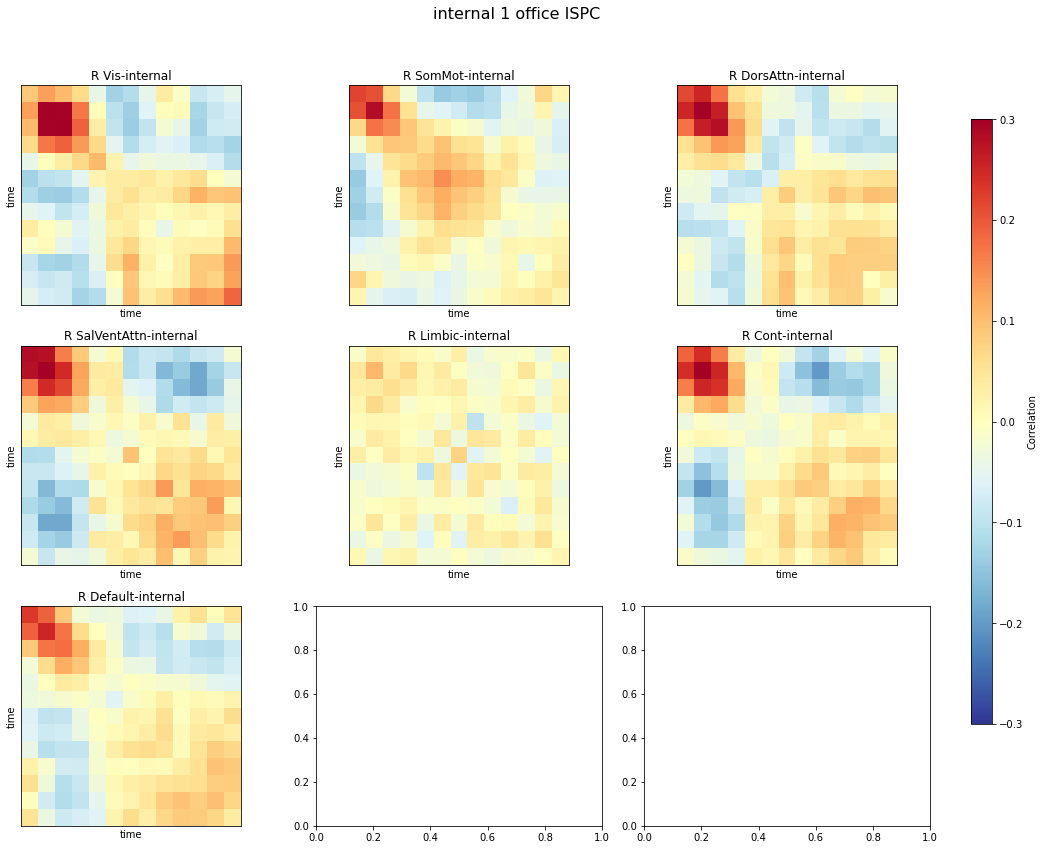

In [144]:
plot_row = 3
plot_col = 3
sub_plot_num = 5

# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.3, 0.3

fig, axs = plt.subplots(plot_row, plot_col, figsize=(15, 12))

for ind, roi in enumerate(targ_dic):
    # calculate ispc
    # Transpose input data to compute intersubject pattern correlation
    ispcs = isfc(np.rollaxis(targ_dic[roi], 1, 0),
                        pairwise=False, vectorize_isfcs=False,
                        summary_statistic='mean')

    
    # First plot: Matrix
    title = f'{roi}'  # Choose the appropriate title
    image = axs[int(ind / plot_col), ind % plot_col].matshow(ispcs, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
    axs[int(ind / plot_col), ind % plot_col].set_title(title)
    axs[int(ind / plot_col), ind % plot_col].set_xticks([])
    axs[int(ind / plot_col), ind % plot_col].set_yticks([])
    axs[int(ind / plot_col), ind % plot_col].set_xlabel('time')
    axs[int(ind / plot_col), ind % plot_col].set_ylabel('time')
    #cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
    #cbar.set_label('Correlation')  # Set colorbar label

# Main title for the entire plot
plt.suptitle(f'{targ_cond} {targ_run} {targ_mov} ISPC', fontsize=16)


# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(image, cax=cbar_ax)
cbar.set_label('Correlation')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the layout to accommodate the main title
plt.show()
    
    

### Analysis B

In [83]:
targ_cond = "external"
#targ_mov = 'oragami'
hemi = 'R'
targ_run = 4 
targ_dic = {} 

targ_keys = [key for key in list(roi_bpress_ispc.keys()) if key[-8:] == targ_cond]  
targ_keys = [key for key in targ_keys if key[:1] == hemi]  
for key in targ_keys:
    targ_dic[key] = roi_bpress_ispc[key][targ_run][targ_mov]

In [84]:
print(f'total networks: {len(list(targ_dic.keys()))} \n hemisphere: {hemi} \n {targ_mov} {targ_run} \n {targ_cond}')
print(f' subjects included: {targ_dic[list(targ_dic.keys())[0]].shape[2]}') 

total networks: 7 
 hemisphere: R 
 office 4 
 external
 subjects included: 13


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


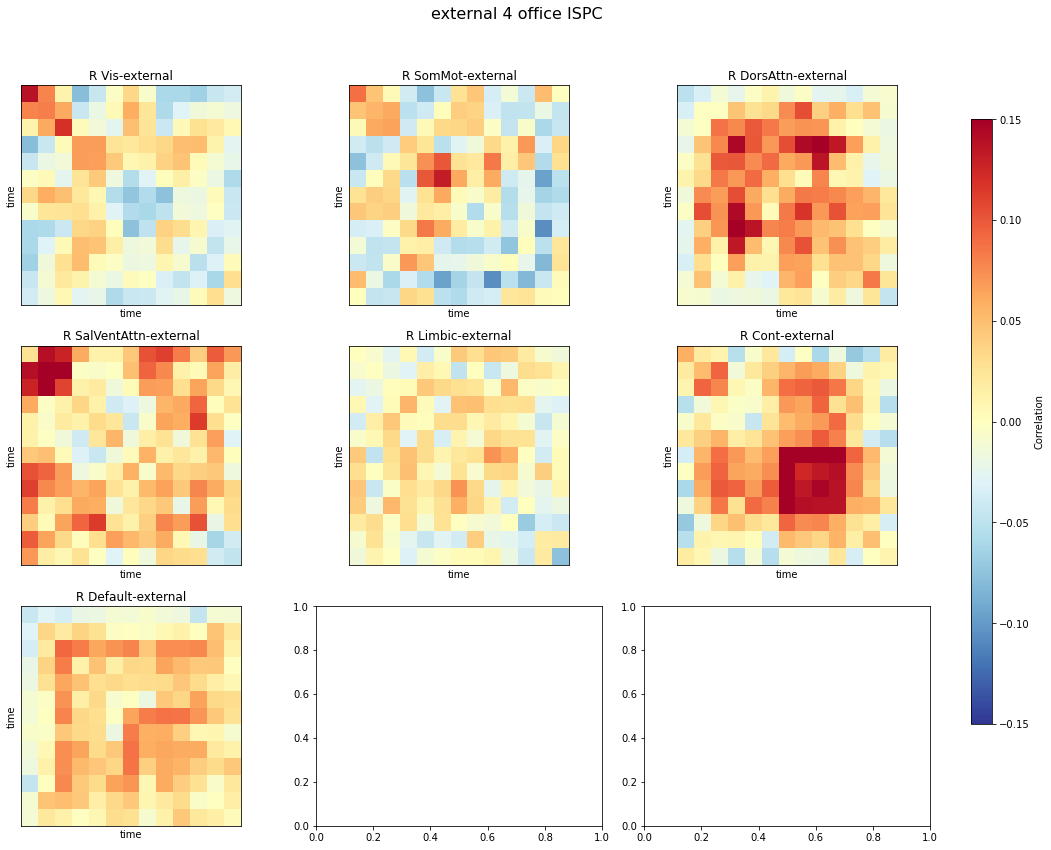

In [85]:
plot_row = 3
plot_col = 3
sub_plot_num = 5

# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.15, 0.15

fig, axs = plt.subplots(plot_row, plot_col, figsize=(15, 12))

for ind, roi in enumerate(targ_dic):
    # calculate ispc
    # Transpose input data to compute intersubject pattern correlation
    ispcs = isfc(np.rollaxis(targ_dic[roi], 1, 0),
                        pairwise=False, vectorize_isfcs=False,
                        summary_statistic='mean')

    
    # First plot: Matrix
    title = f'{roi}'  # Choose the appropriate title
    image = axs[int(ind / plot_col), ind % plot_col].matshow(ispcs, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
    axs[int(ind / plot_col), ind % plot_col].set_title(title)
    axs[int(ind / plot_col), ind % plot_col].set_xticks([])
    axs[int(ind / plot_col), ind % plot_col].set_yticks([])
    axs[int(ind / plot_col), ind % plot_col].set_xlabel('time')
    axs[int(ind / plot_col), ind % plot_col].set_ylabel('time')
    #cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
    #cbar.set_label('Correlation')  # Set colorbar label

# Main title for the entire plot
plt.suptitle(f'{targ_cond} {targ_run} {targ_mov} ISPC', fontsize=16)


# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(image, cax=cbar_ax)
cbar.set_label('Correlation')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the layout to accommodate the main title
plt.show()
    
    

## One Network

In [29]:
test = np.load(f'{isc_dir}/roi_bpress_ispc.npy', allow_pickle = True).item()
#x = np.load(f'{isc_dir}/ext_isc.npz', mmap_mode='r')

In [23]:
#anal = m_rep_int[4]['sherlock']
anal = m_rep_ext[1]['sherlock']
anal.shape

(13, 1124, 9)

In [24]:
# Transpose input data to compute intersubject pattern correlation
ispcs = isfc(np.rollaxis(anal, 1, 0),
                    pairwise=False, vectorize_isfcs=False,
                    summary_statistic='mean')

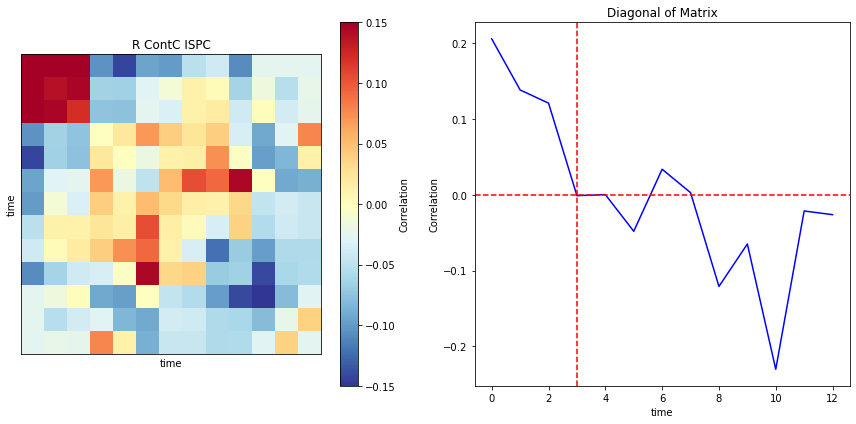

In [25]:
# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.15, 0.15

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Matrix
ispc = ispcs  # Choose the matrix to plot (intact_ispcs or scram_ispcs)
title = f'{net_lab} ISPC'  # Choose the appropriate title
image = axs[0].matshow(ispc, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axs[0].set_title(title)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('time')
axs[0].set_ylabel('time')
cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
cbar.set_label('Correlation')  # Set colorbar label

# Second plot: Seaborn lineplot with vertical line
diagonal = np.diagonal(ispc)
time_points = np.arange(len(diagonal))
axs[1] = sns.lineplot(x=time_points, y=diagonal, color='blue')
axs[1].set_title('Diagonal of Matrix')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Correlation')
axs[1].axvline(x=3, color='red', linestyle='--')  # Vertical line at the third tick
axs[1].axhline(y=0, color='red', linestyle='--')  # Horizotnal line at 0


plt.tight_layout()
plt.show()


# Plot networks

### load atlas 

In [24]:
num_parc = 400

## should be 17 to run
num_net= 7

In [25]:
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


### get network labels

In [26]:
# Load in network labels for each parcell, ALL network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)


two networks: ['L Vis', 'L SomMot'] 
 total nets: 14


In [11]:
# **7 NETWORK Get labels for parcels in left DMN A network** ## 
net_lab = 'R DorsAttn'

## Target Conditions
targ_cond = "External"

## movie repetitions ##
#m_reps = 1
targ_run = 1

## Get labels associated with the target network ## 
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1


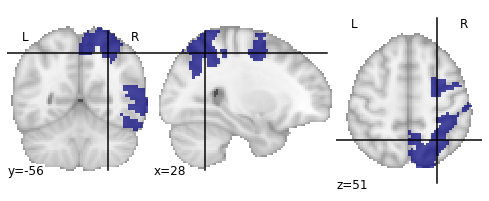

In [13]:
# Create an empty that is the shape of d
roi_tem = np.zeros(atlas_nii.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
for parcel in targ_net:
    roi_tem[atlas_img == parcel] = 1
    
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)
#nib.save(roi_img, rois_dir+'/'+ roi_name.decode("utf-8"))


mPFC_coords = (10,10, 45)
pcc_coords = (10,-40, 45)

#plot_roi(roi_img,cut_coords = pcc_coords)
plot_roi(roi_img)